# Data Science Workflow: Beijing PM2.5 Analysis


## 1) Business Understanding

1. **How do meteorological factors influence PM2.5 air pollution levels in Beijing?**
2. **Can we have a model to forecast the PM2.5 levels**
3. **How does feature engineering (such as lagged and rolling features) impact the accuracy of PM2.5 forecasts?**

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
import numpy as np 
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

pd.set_option('mode.chained_assignment', None)

beijing_pm2_5 = fetch_ucirepo(id=381) 
features_list = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']

## 2) Data Understanding

## Gather

Load the Beijing PM2.5 dataset and import required libraries.

In [2]:
df = beijing_pm2_5['data']['original']

## Assess

Based on running df.head(100), we observe that:

1. There are missing values. We will need to impute them. I have chosen bfill since we can impute it based on the data in later time frame
2. `cbwd` column requires to be one-hot encoded, since these are categorical data. 


In [ ]:
# concatenate year, month, day, hour into a datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

In [4]:
df.head(100)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,2010,1,4,23,31.0,-26,-15.0,1035.0,NW,198.45,0,0
96,97,2010,1,5,0,30.0,-26,-17.0,1035.0,NW,201.58,0,0
97,98,2010,1,5,1,34.0,-26,-18.0,1035.0,NW,205.60,0,0
98,99,2010,1,5,2,27.0,-26,-19.0,1035.0,NW,208.73,0,0


## Univariate Analysis


## Analyze

Explore distributions, relationships, and correlations between features.

In [ ]:
def plot_univariate_plots(df: pd.DataFrame) -> None:
    """
    Plot univariate time series for selected features.

    Args:
        df (pd.DataFrame): DataFrame with datetime and feature columns.
    """
    features = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
    titles = ['PM2.5', 'Dew Point', 'Temperature', 'Pressure', 'Iws', 'Is', 'Ir']

    # Create 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.lineplot(data=df, x='datetime', y=feature, ax=axes[i])
        axes[i].set_title(f'{titles[i]} over time in Beijing')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(feature)

    # Hide unused subplot
    if len(features) < len(axes):
        axes[-1].set_visible(False)

    plt.tight_layout()
    plt.show()


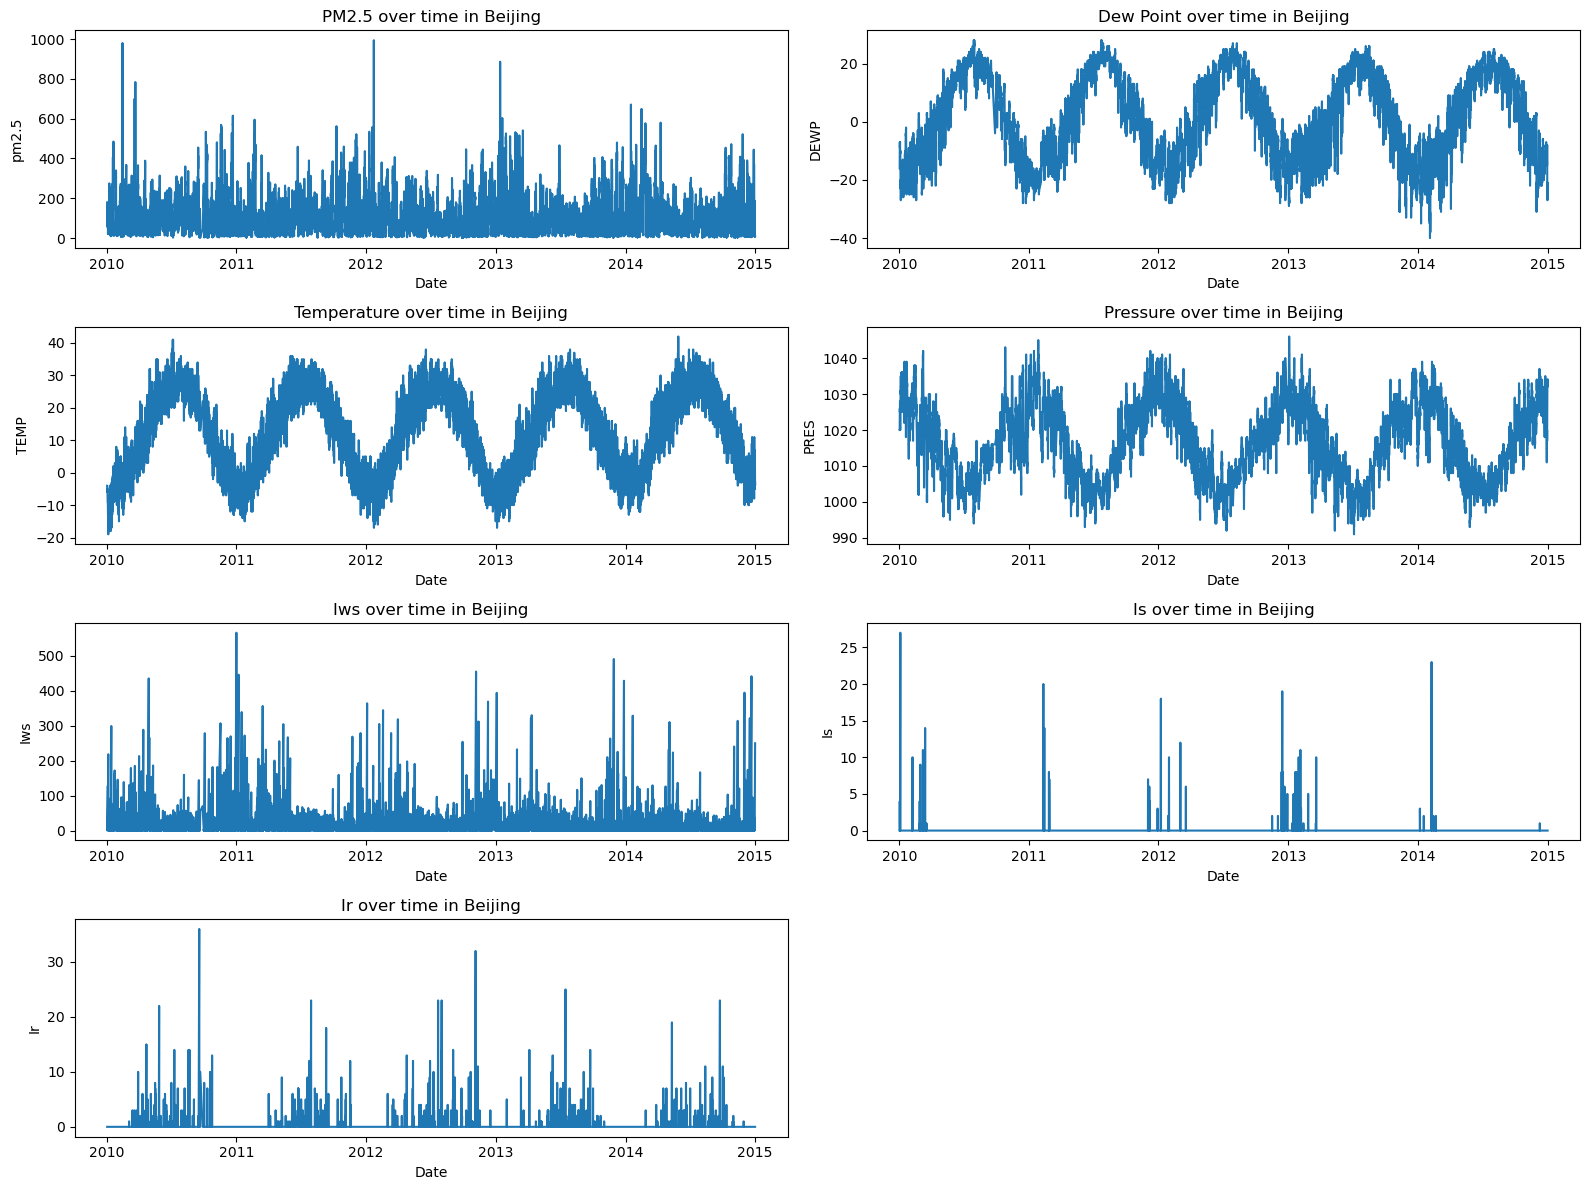

In [ ]:
# plotting for full timespan of the dataset
plot_univariate_plots(df)

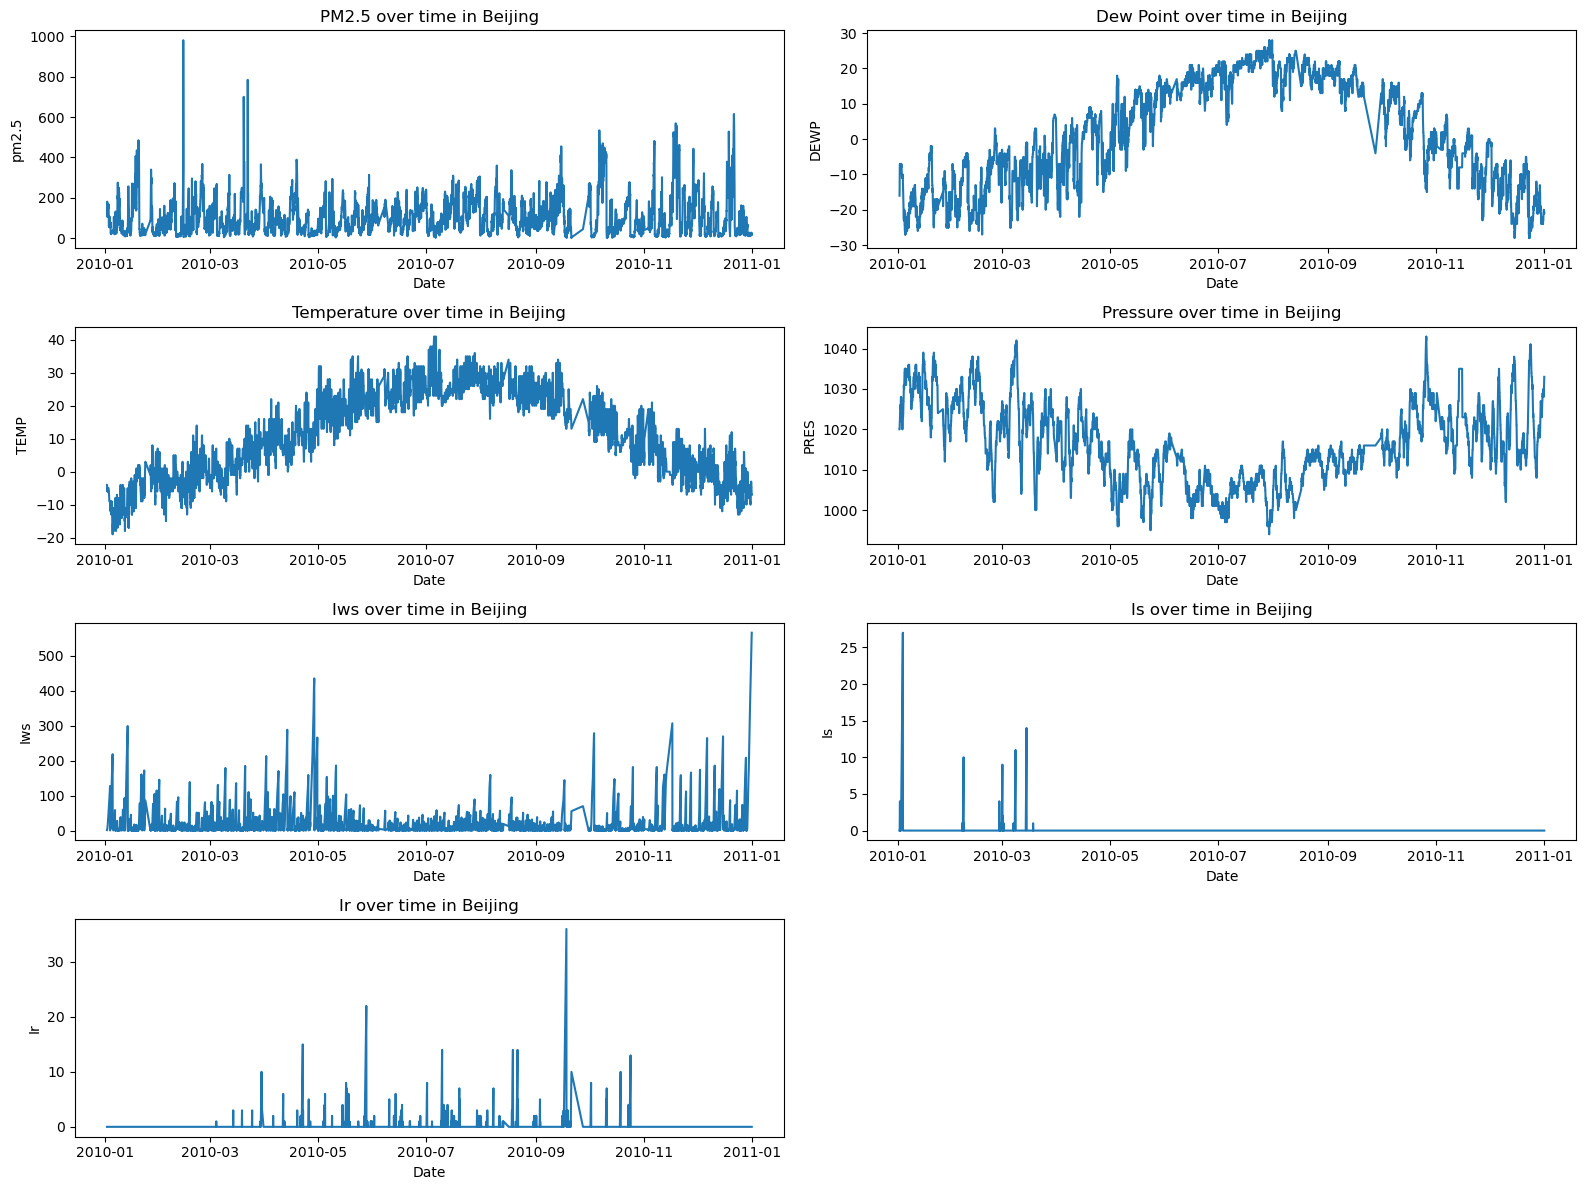

In [ ]:
df_2010 = df[df['year'] == 2010]
plot_univariate_plots(df_2010)

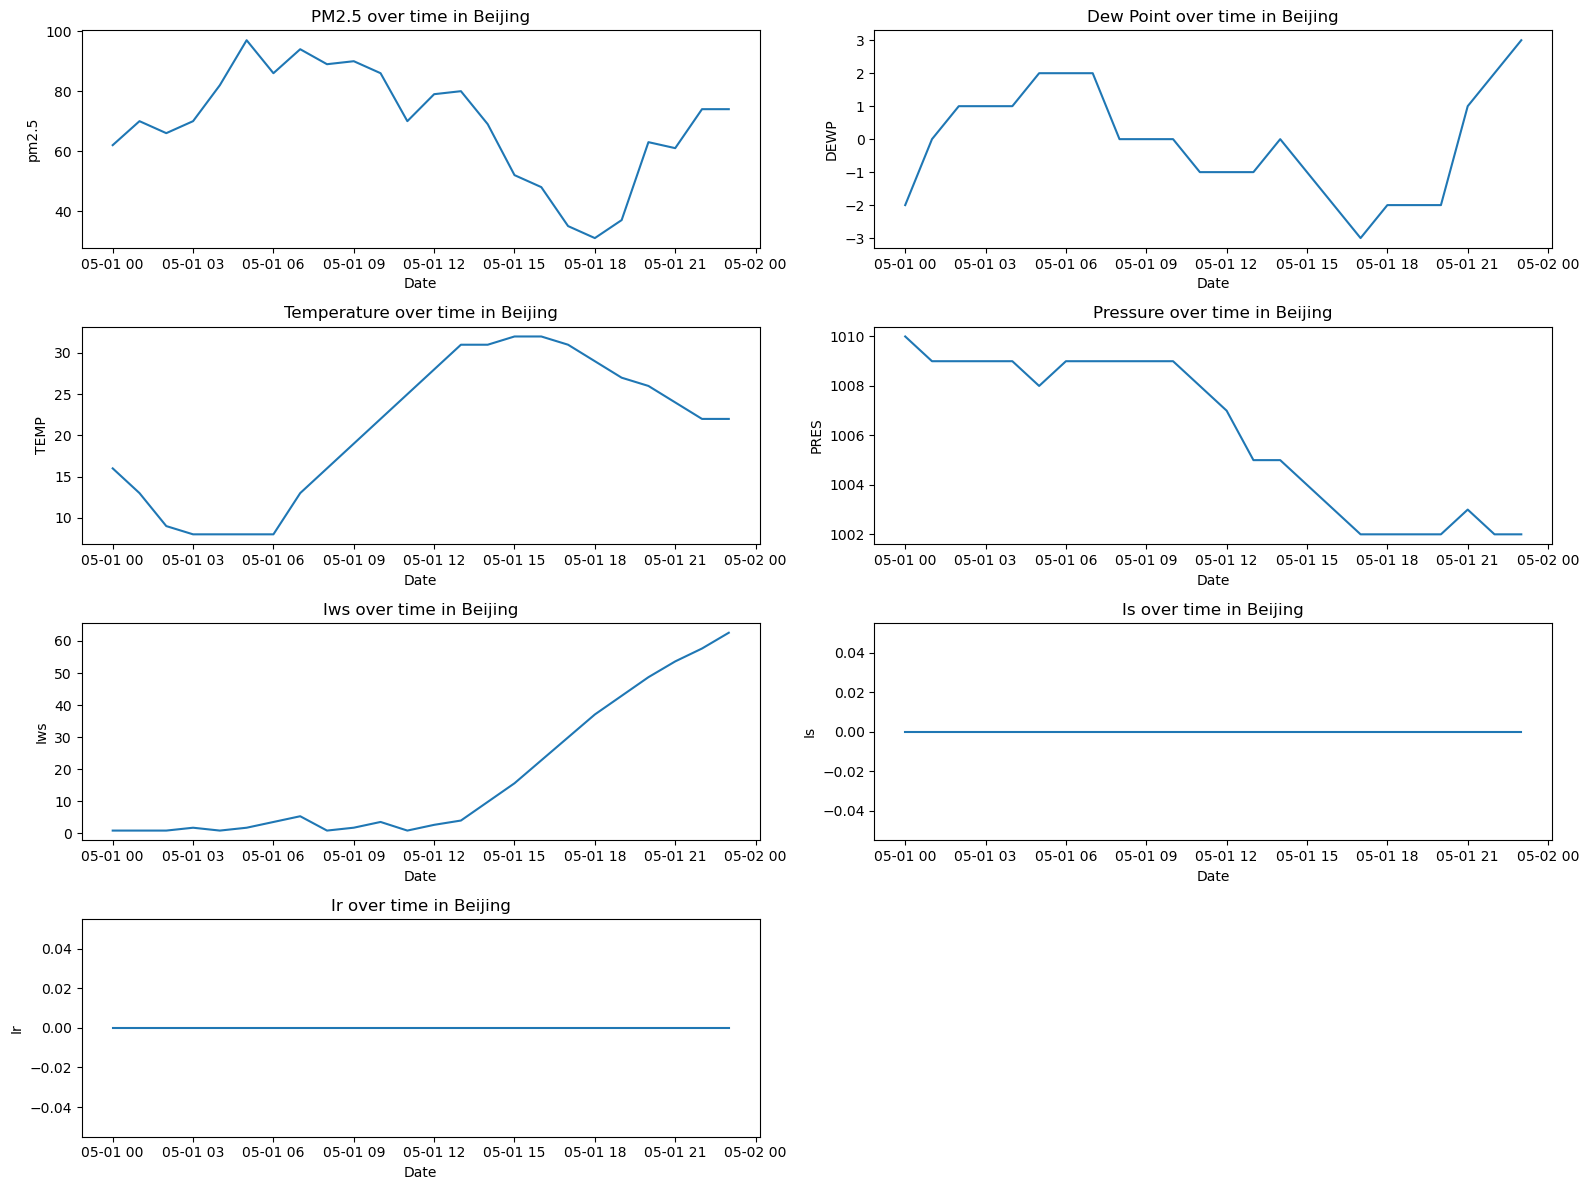

In [ ]:
df_day = df[(df['year'] == 2010) & (df['month'] == 5) & (df['day'] == 1)]
plot_univariate_plots(df_day)

## Histogram Analysis

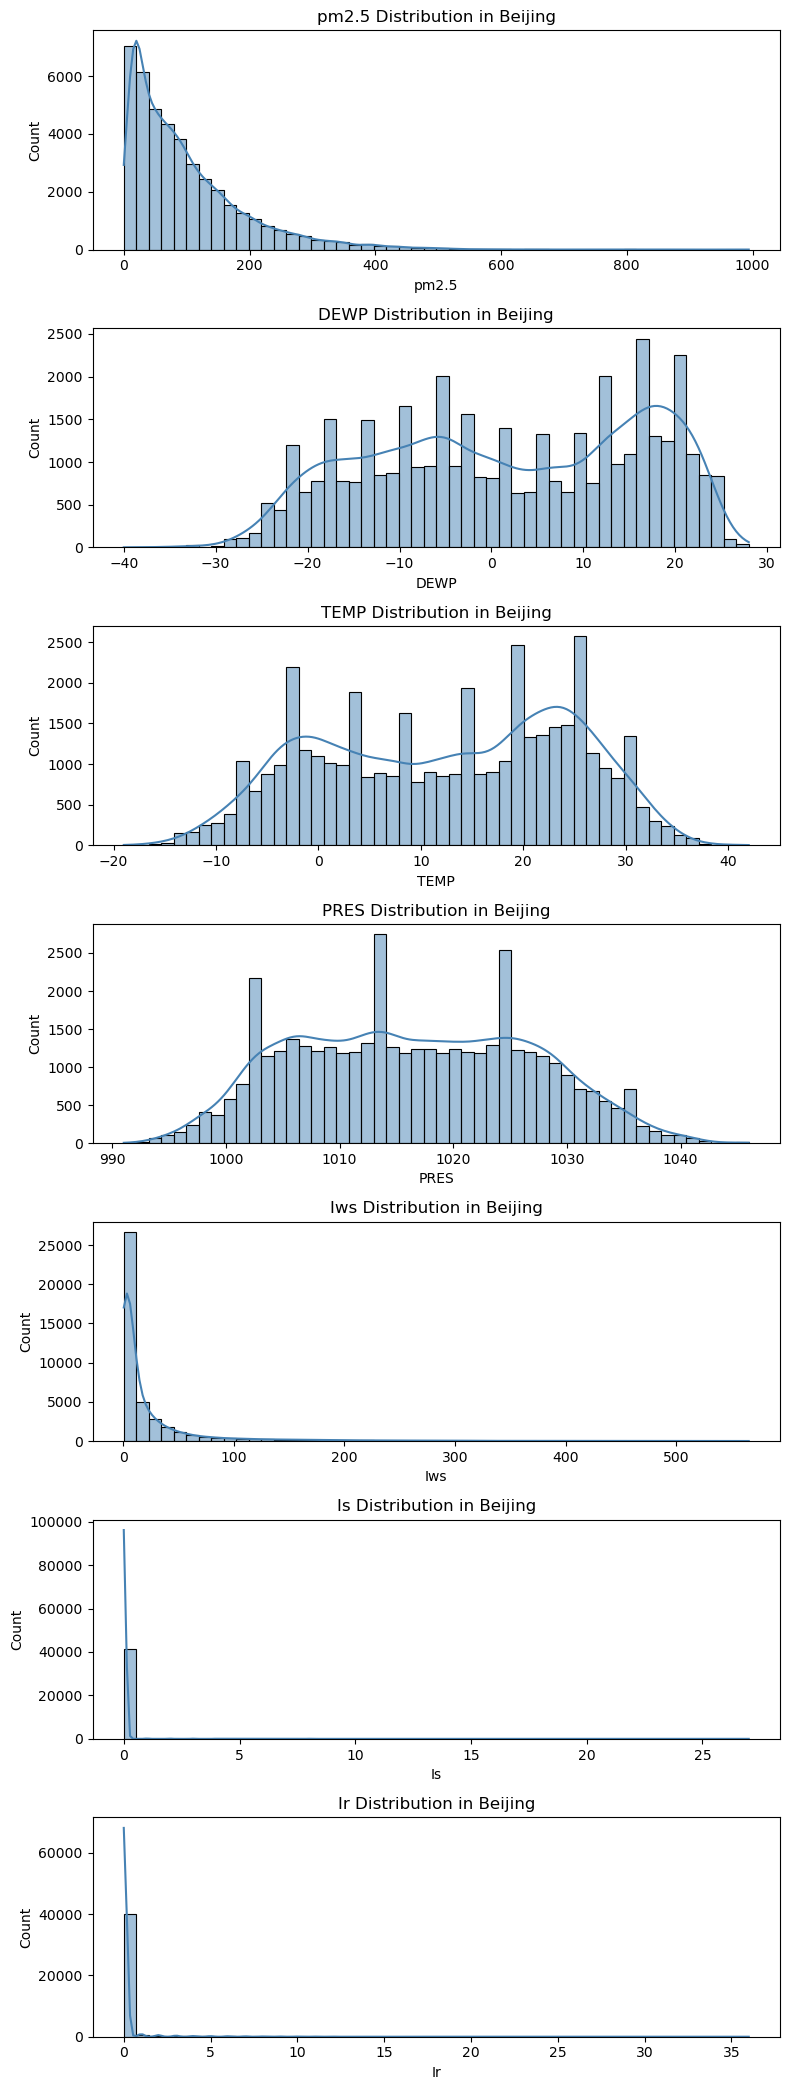

In [ ]:
def plot_feature_histograms(df: pd.DataFrame, features: list[str]) -> None:
    """
    Plot histograms for selected features.

    Args:
        df (pd.DataFrame): DataFrame with feature columns.
        features (list[str]): List of feature names to plot.
    """
    fig, axes = plt.subplots(len(features), 1, figsize=(8, 3 * len(features)))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.histplot(df[feature], bins=50, kde=True, ax=axes[i], color='steelblue')
        axes[i].set_title(f'{feature} Distribution in Beijing')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


## Question 1: How do meteorological factors influence PM2.5 air pollution levels in Beijing?

We can run some bivariate analysis for this. I have made the conclusions for it below. 

## Bivariate Analysis 

We start by looking at the scatterplot of one feature in relation with another feature

Observation - PRES and DEWP have a negative correlation with each other. 

For PM2.5, there are numerous peaks and values, but they tend to peak when:

TEMP is relatively low   
PRES is relatively high  
DEWP is average  


In [ ]:
def plot_scatter(df: pd.DataFrame, y_feature: str, features_list: list[str]) -> None:
    """
    Plot scatterplots of y_feature against other features.

    Args:
        df (pd.DataFrame): DataFrame with features.
        y_feature (str): Target feature for y-axis.
        features_list (list[str]): List of features to compare.
    """
    feature_list_mod = [f for f in features_list if f != y_feature]
    n_features = len(feature_list_mod)

    # Create one subplot per feature
    fig, axes = plt.subplots(n_features, 1, figsize=(6, 3 * n_features))
    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(feature_list_mod):
        sns.scatterplot(data=df, x=feature, y=y_feature, ax=axes[i], color='steelblue', s=10)
        axes[i].set_title(f'{y_feature} vs {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(y_feature)

    plt.tight_layout()
    plt.show()


In [ ]:
# df correlations
corr = df[['pm2.5', 'PRES', 'TEMP','DEWP']].corr()
corr

,pm2.5,PRES,TEMP,DEWP
pm2.5,1.000000,-0.047282,-0.090534,0.171423
PRES,-0.047282,1.000000,-0.826903,-0.777722
TEMP,-0.090534,-0.826903,1.000000,0.823821
DEWP,0.171423,-0.777722,0.823821,1.000000


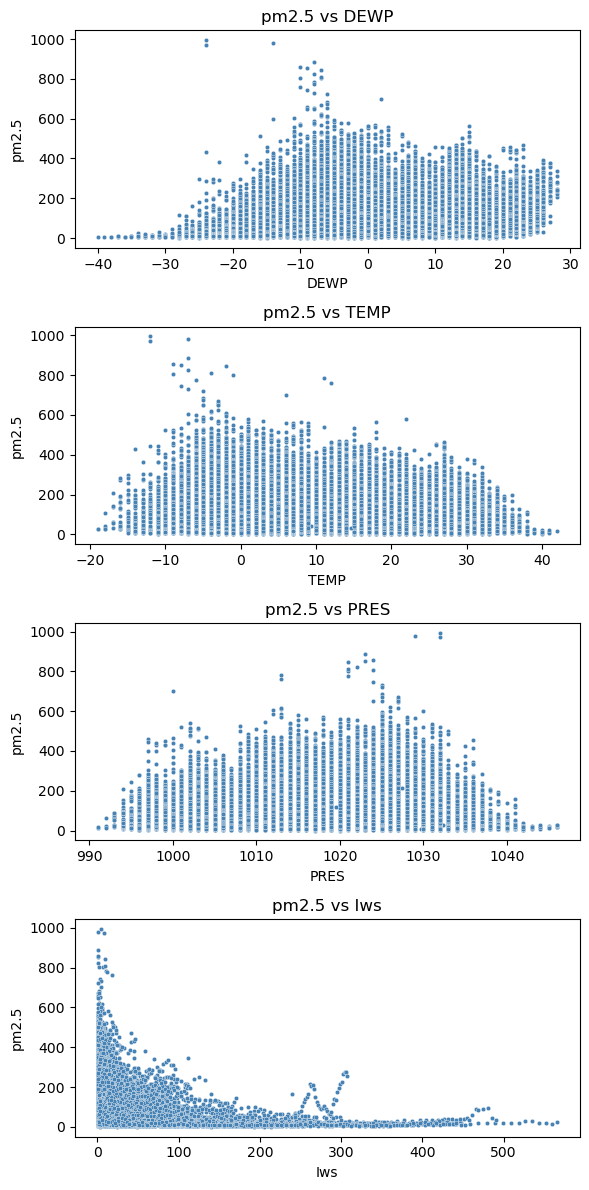

In [ ]:
plot_scatter(df, 'pm2.5', features_list)

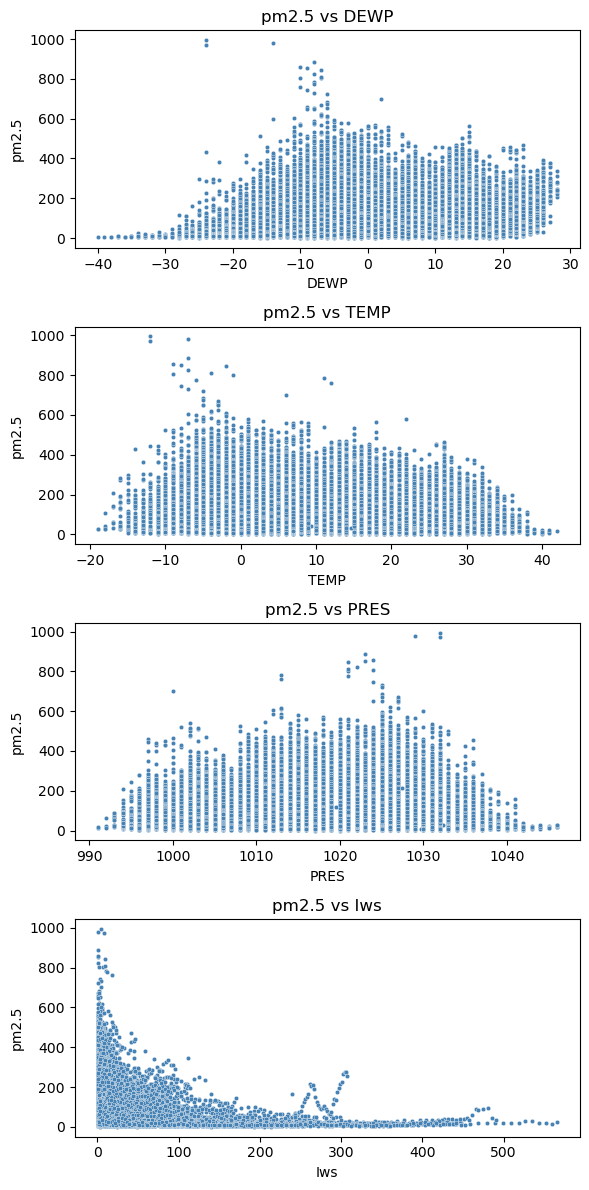

In [ ]:
plot_scatter(df, 'pm2.5', features_list)

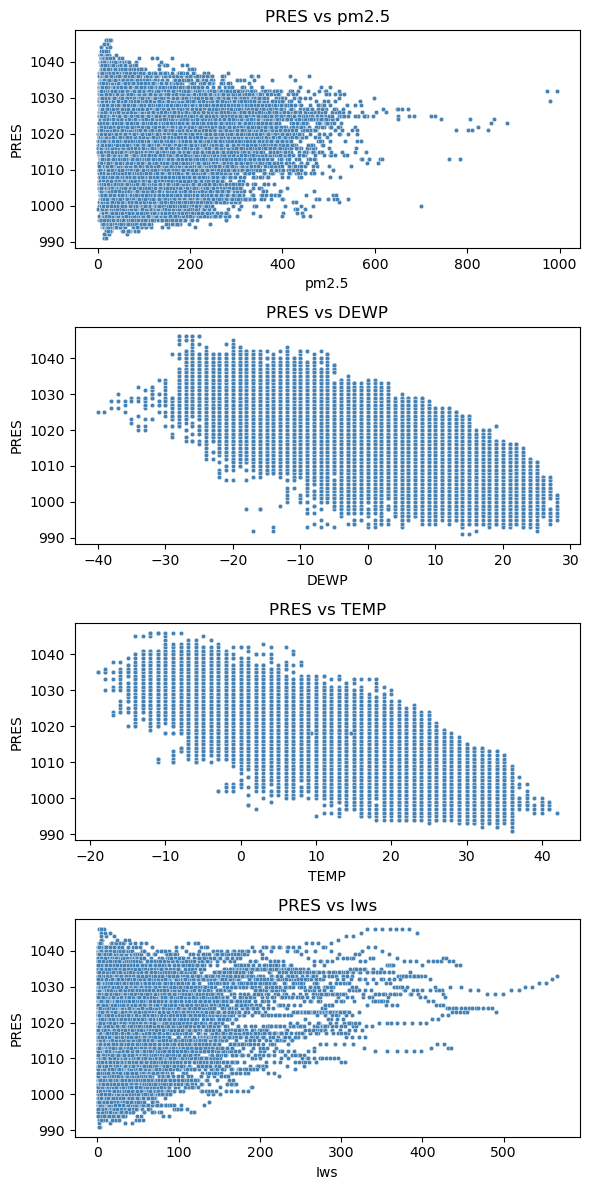

In [ ]:
plot_scatter(df, 'PRES', features_list)

### Spurious Correlation

A spurious correlation is where you find two variables that appear to be correlated to each other, but in reality they are not. This may occur because a third (hidden) variable is influencing both variables. Another reason why it may occur is just coincidence. 

In [ ]:
def make_diff_plots(df: pd.DataFrame, n_periods: int = 5) -> None:
    """
    Plot differenced and original scatterplots for PRES and TEMP.

    Args:
        df (pd.DataFrame): DataFrame with PRES and TEMP columns.
        n_periods (int): Number of periods for differencing.
    """
    pres_diff = df['PRES'].diff(periods=n_periods)
    temp_diff = df['TEMP'].diff(periods=n_periods)

    # Compute and print correlation
    corr_value = pres_diff.corr(temp_diff)
    print(f"Correlation between PRES and TEMP with a time period of {n_periods}: {corr_value:.4f}")

    # Create subplots: differenced and original
    fig, axes = plt.subplots(2, 1, figsize=(6, 8))
    sns.scatterplot(x=pres_diff, y=temp_diff, ax=axes[0], color='teal', s=15)
    axes[0].set_title(f'PRES_diff vs TEMP_diff (lag={n_periods})')
    axes[0].set_xlabel(f'PRES Difference ({n_periods})')
    axes[0].set_ylabel(f'TEMP Difference ({n_periods})')

    sns.scatterplot(x=df['PRES'], y=df['TEMP'], ax=axes[1], color='steelblue', s=15)
    axes[1].set_title('PRES vs TEMP (Original)')
    axes[1].set_xlabel('PRES')
    axes[1].set_ylabel('TEMP')

    plt.tight_layout()
    plt.show()


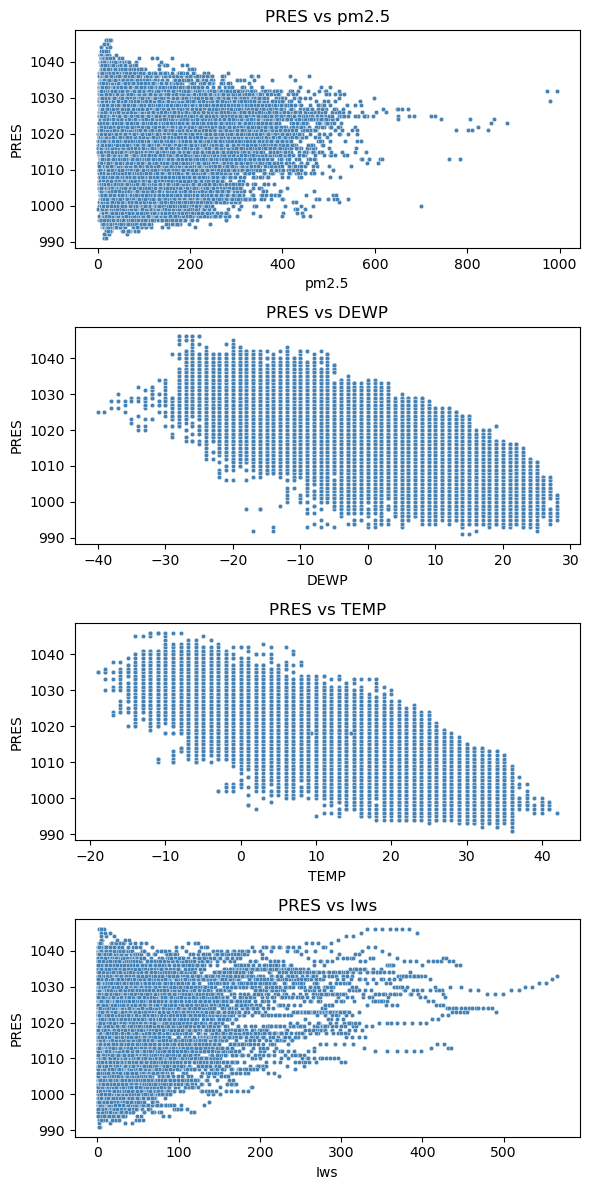

In [ ]:
plot_scatter(df, 'PRES', features_list)

## Autocorrelation Analysis

We check if the datapoint are autocorrelated. That is, if past datapoints influence future datapoints. 

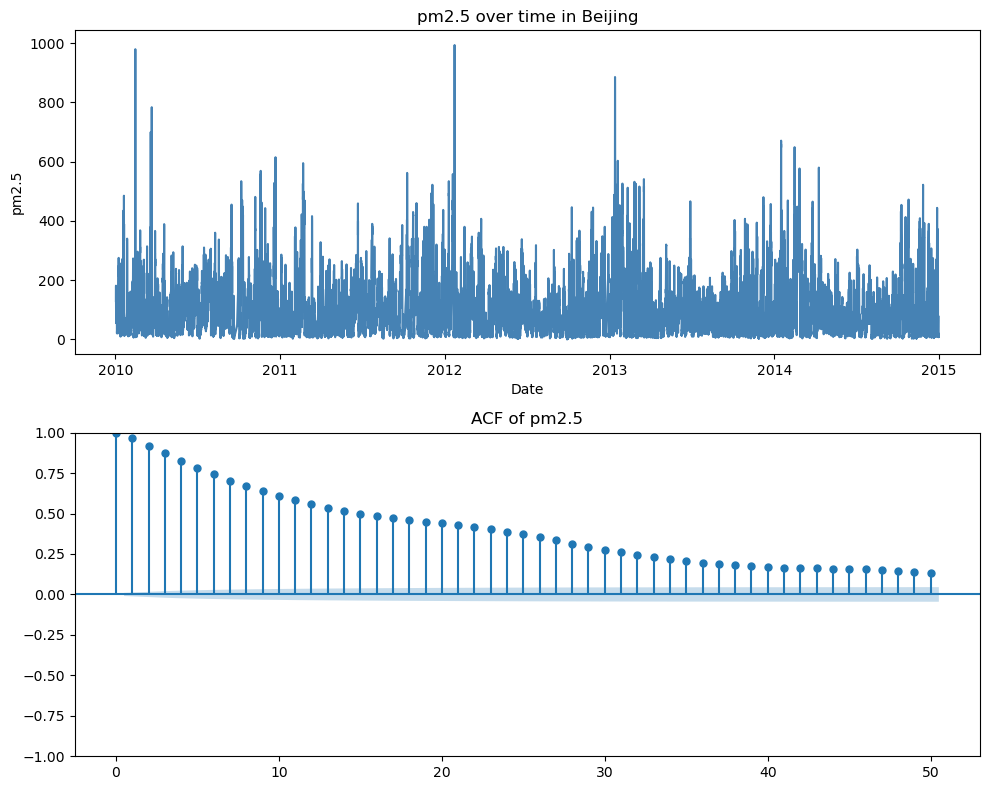

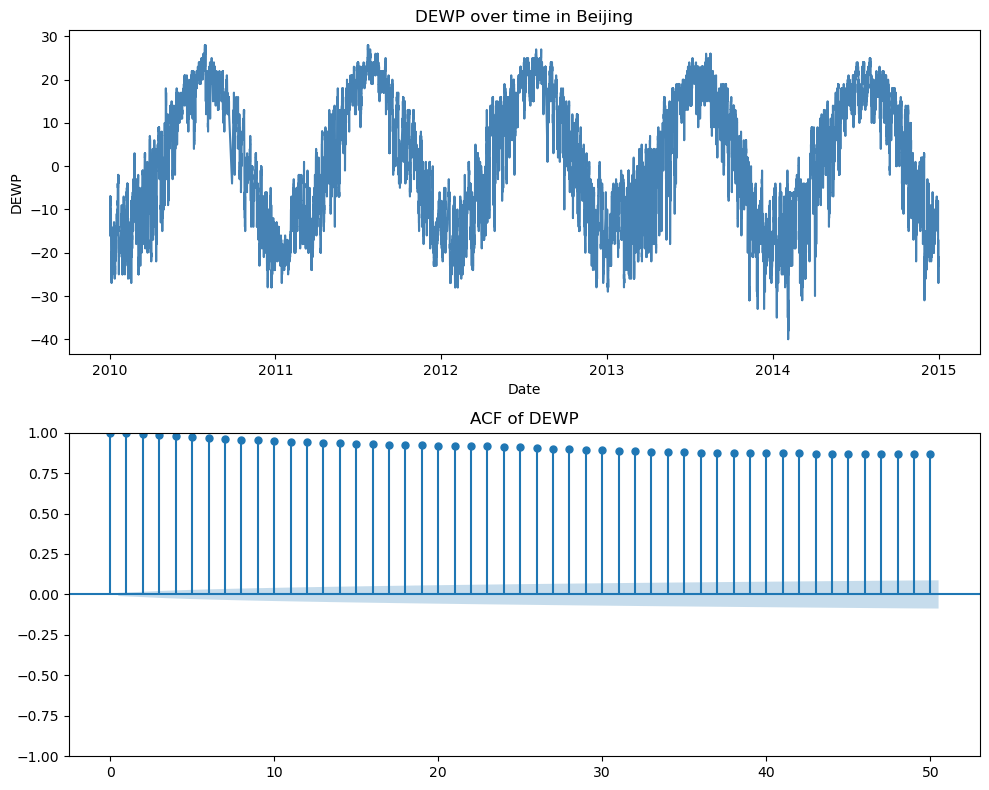

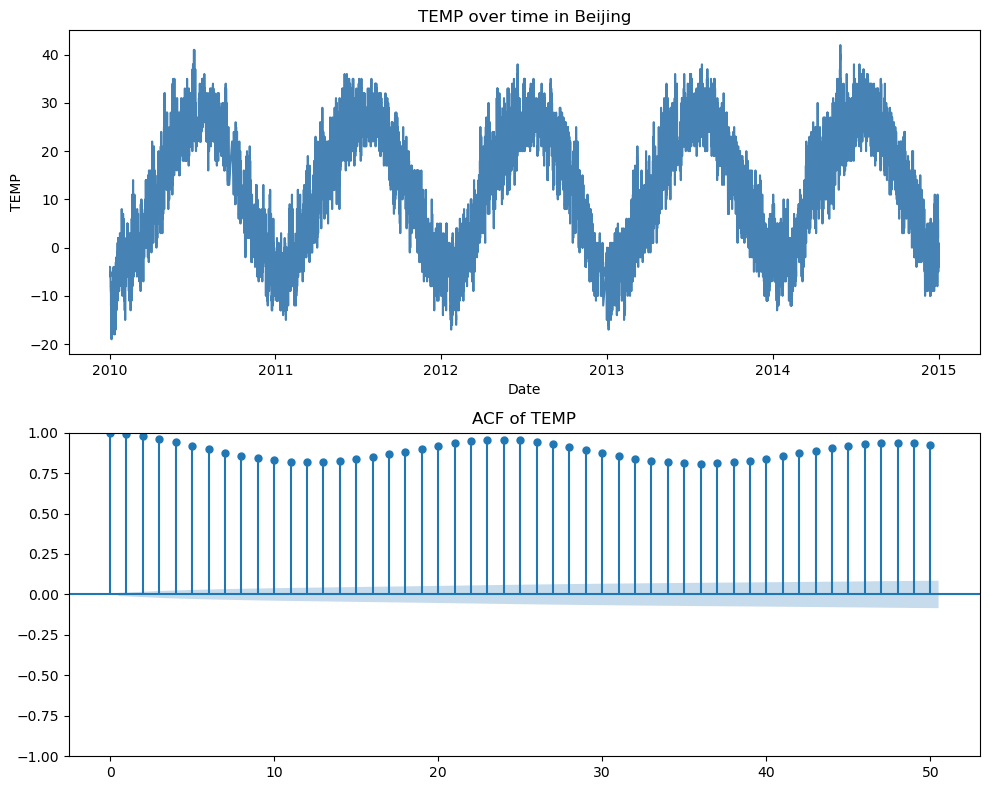

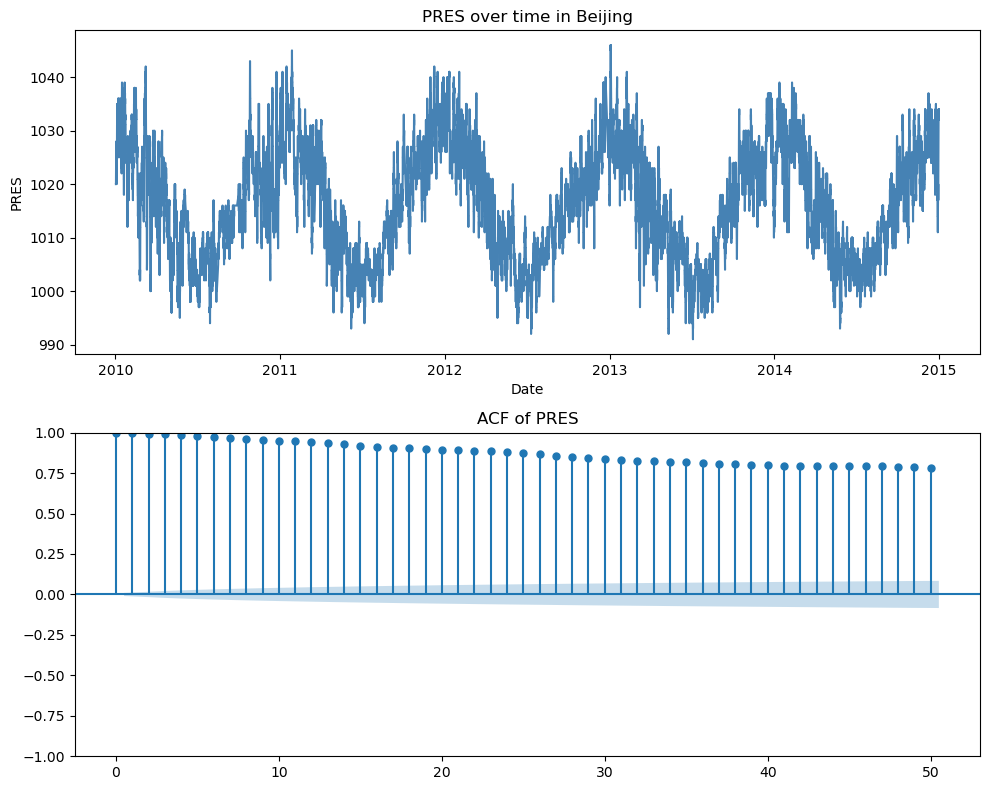

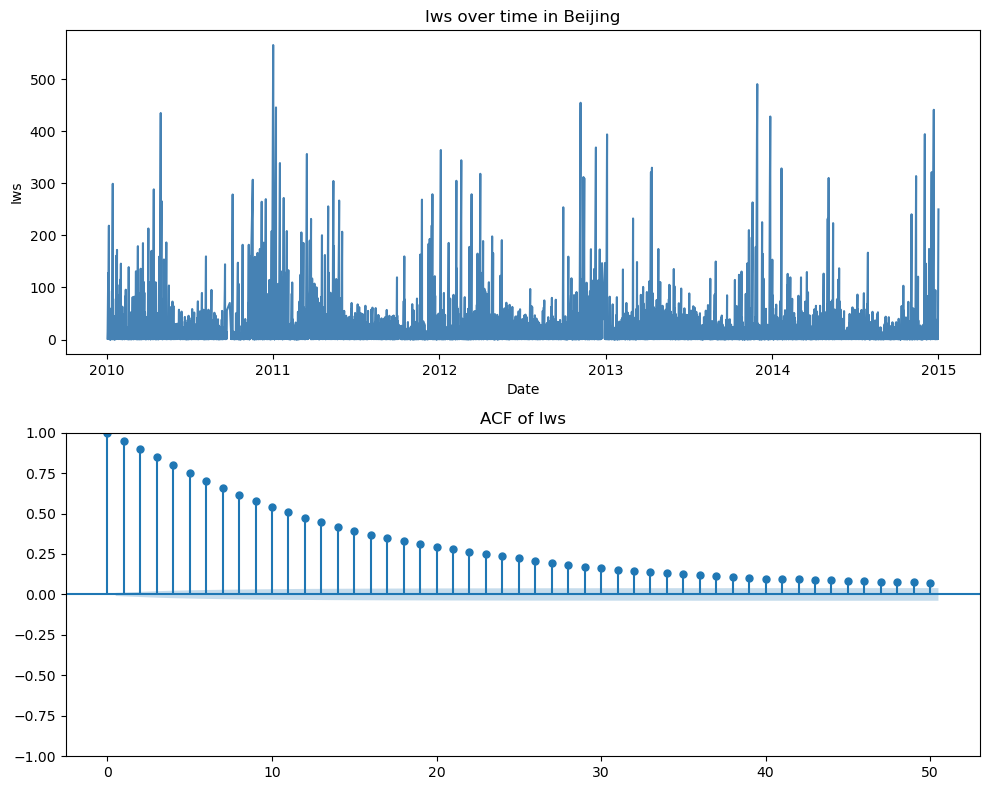

In [ ]:
# acf plots for each feature
# as well as the corresponding univariate plot

for feature in features_list:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    sns.lineplot(data=df, x='datetime', y=feature, ax=axes[0], color='steelblue')
    axes[0].set_title(f'{feature} over time in Beijing')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel(feature)

    plot_acf(df[feature].dropna(), lags=50, ax=axes[1])
    axes[1].set_title(f'ACF of {feature}')

    plt.tight_layout()
    plt.show()

## Conclusions from Exploratory Data Analysis (EDA)


- **PM2.5 levels** in Beijing show significant variability over time, with frequent peaks during colder months and lower temperatures.
- **Correlation matrix:**

|         | pm2.5    | PRES     | TEMP     | DEWP     |
|---------|----------|----------|----------|----------|
| pm2.5   | 1.000000 | -0.047282| -0.090534| 0.171423 |
| PRES    | -0.047282| 1.000000 | -0.826903| -0.777722|
| TEMP    | -0.090534| -0.826903| 1.000000 | 0.823821 |
| DEWP    | 0.171423 | -0.777722| 0.823821 | 1.000000 |

- **Temperature (TEMP)** and **Dew Point (DEWP)** are strongly positively correlated, while **Pressure (PRES)** is strongly negatively correlated with both.
- **High PM2.5 concentrations** often coincide with low temperatures and high pressure, suggesting that weather conditions play a key role in air quality.
- **Histograms** reveal that most features, especially PM2.5, are right-skewed, indicating occasional extreme pollution events.
- **Bivariate scatterplots** show clear relationships between PM2.5 and other meteorological variables, with some features (like Iws) showing less direct association.
- **Autocorrelation analysis** indicates that most features, especially PM2.5, exhibit strong temporal autocorrelation, meaning past values influence future values.
- **Spurious correlations** can arise due to time series effects; differencing the data reduces apparent correlations between some features.

**Overall, the EDA highlights the complex interplay between meteorological factors and air pollution in Beijing, with strong evidence of seasonality, autocorrelation, and the influence of weather on PM2.5 levels.**

We shall now move to the next notebook, `forecasting`, to MODEL and EVALUATE the model results. 